In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv("fer2013.csv")

In [3]:
data = data.drop('Usage', axis=1)

In [4]:
data

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [5]:
images = []
labels = []

In [6]:
for index, row in data.iterrows():
    image = np.fromstring(row['pixels'], dtype=int, sep=' ')
    image = np.reshape(image, (48, 48, 1))
    image = image.astype('float32')/255
    images.append(image)
    labels.append(row['emotion'])

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

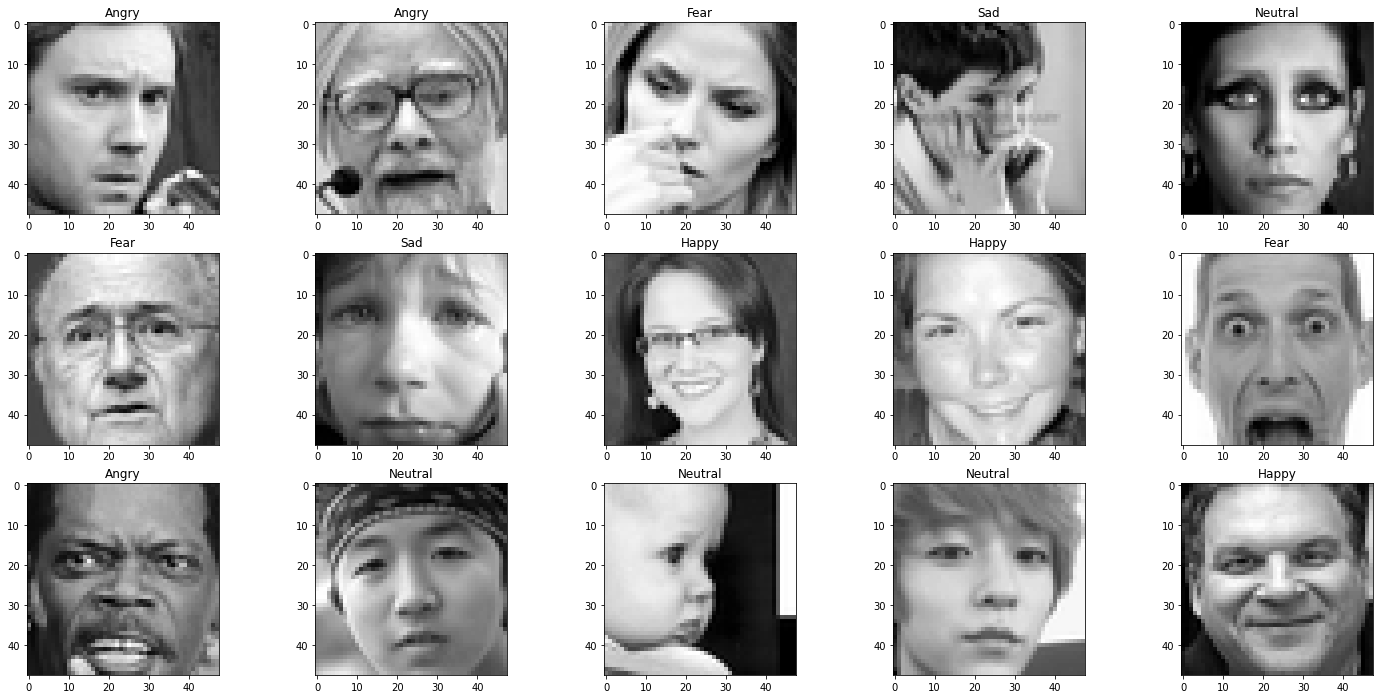

In [8]:
fig, axs = plt.subplots(3, 5, figsize=(25, 12))
axs = axs.ravel()
for i in range(15):
    axs[i].imshow(images[i][:,:,0], cmap='gray')
    axs[i].set_title(str(emotions[labels[i]]))

In [9]:
labels = to_categorical(labels)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=27021994)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=27021994)

In [10]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [11]:
model = tf.keras.models.Sequential([])
model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(48,48,1)))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Dropout(.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(7, activation='softmax'))
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history=model.fit(
    x=train_images, 
    y=train_labels,
    epochs=30,
    callbacks=my_callbacks,
    validation_data=(val_images, val_labels),
    batch_size=32
)

Epoch 1/30
673/673 [==============================] - 30s 43ms/step - loss: 1.8189 - accuracy: 0.2742 - val_loss: 1.5387 - val_accuracy: 0.3952
Epoch 2/30
673/673 [==============================] - 27s 40ms/step - loss: 1.5291 - accuracy: 0.4096 - val_loss: 1.4460 - val_accuracy: 0.4281
Epoch 3/30
673/673 [==============================] - 27s 40ms/step - loss: 1.4181 - accuracy: 0.4607 - val_loss: 1.3822 - val_accuracy: 0.4691
Epoch 4/30
673/673 [==============================] - 27s 40ms/step - loss: 1.3655 - accuracy: 0.4798 - val_loss: 1.3015 - val_accuracy: 0.4936
Epoch 5/30
673/673 [==============================] - 27s 40ms/step - loss: 1.3305 - accuracy: 0.4852 - val_loss: 1.3535 - val_accuracy: 0.4850


In [12]:
predictions=[np.argmax(im) for im in model.predict(test_images)]
labels = [np.argmax(i) for i in test_labels]
accuracy_score(predictions,labels)

0.48843689049874617

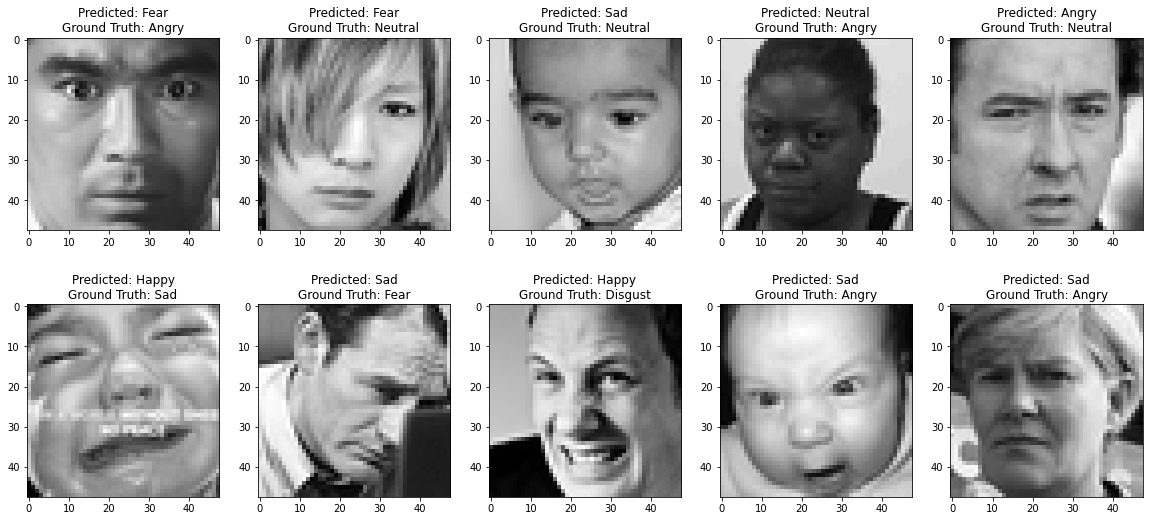

In [13]:
cols = 0
rows = 0
disagree = []

for i in range(len(labels)):
    if labels[i] != predictions[i]:
        disagree.append(i)
        if len(disagree) == 10:
            break

fig, axs = plt.subplots(2, 5, figsize=(20,9))

for i in range(10):
    image=(np.array(list(test_images)[disagree[i]])/256)[:,:,0]
    axs[cols, rows].imshow(image, cmap='gray')
    axs[cols, rows].set_title('Predicted: ' + str(emotions[predictions[disagree[i]]]) + '\nGround Truth: ' + str(emotions[labels[disagree[i]]]))
    rows = rows+1
    if rows == 5:
        cols = cols + 1
        rows = 0